In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm 
from pathlib import Path


In [3]:
# -------------------------------
# Enhancement Functions
# -------------------------------

def noise_reduction(img, method='bilateral'):
    if method == 'gaussian':
        return cv2.GaussianBlur(img, (5, 5), 0)
    elif method == 'median':
        return cv2.medianBlur(img, 5)
    elif method == 'bilateral':
        return cv2.bilateralFilter(img, 9, 75, 75)
    return img

def contrast_enhancement(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge([l_clahe, a, b])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

def brightness_normalization(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_norm = cv2.normalize(l, None, 0, 255, cv2.NORM_MINMAX)
    lab_norm = cv2.merge([l_norm, a, b])
    return cv2.cvtColor(lab_norm, cv2.COLOR_LAB2BGR)

def enhance_image_pipeline(img):
    denoised = noise_reduction(img, method='bilateral')
    enhanced = contrast_enhancement(denoised)
    normalized = brightness_normalization(enhanced)
    return denoised, enhanced, normalized

def calculate_metrics(original, enhanced):
    gray_orig = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    gray_enh = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    psnr = cv2.PSNR(original, enhanced)
    contrast_orig = np.std(gray_orig)
    contrast_enh = np.std(gray_enh)
    sharp_orig = cv2.Laplacian(gray_orig, cv2.CV_64F).var()
    sharp_enh = cv2.Laplacian(gray_enh, cv2.CV_64F).var()
    return {
        'psnr': psnr,
        'contrast_orig': contrast_orig,
        'contrast_enh': contrast_enh,
        'sharpness_orig': sharp_orig,
        'sharpness_enh': sharp_enh
    }


In [4]:
# -------------------------------
# Batch Processing Section
# -------------------------------

input_folder = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words"
output_folder = "/kaggle/working/enhanced_training_words"

os.makedirs(output_folder, exist_ok=True)
results = []

# Get all image files
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Found {len(image_files)} images in training_words folder.")
print("Starting batch enhancement...\n")


for img_name in tqdm(image_files):
    img_path = os.path.join(input_folder, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read {img_name}")
        continue
    
    # Process image
    denoised, enhanced, normalized = enhance_image_pipeline(img)
    
    # Save final normalized image
    save_path = os.path.join(output_folder, img_name)
    cv2.imwrite(save_path, normalized)
    
    # Compute metrics
    metrics = calculate_metrics(img, normalized)
    metrics['filename'] = img_name
    results.append(metrics)


# -------------------------------
# Save metrics summary
# -------------------------------
df = pd.DataFrame(results)
csv_path = os.path.join(output_folder, "enhancement_metrics.csv")
df.to_csv(csv_path, index=False)

print("\n✅ Processing complete!")
print(f"Enhanced images saved to: {output_folder}")
print(f"Metrics saved to: {csv_path}")

# Display summary stats
print("\nAverage Metrics:")
print(df[['psnr', 'contrast_enh', 'sharpness_enh']].mean())


Found 3120 images in training_words folder.
Starting batch enhancement...



100%|██████████| 3120/3120 [00:41<00:00, 74.36it/s]



✅ Processing complete!
Enhanced images saved to: /kaggle/working/enhanced_training_words
Metrics saved to: /kaggle/working/enhanced_training_words/enhancement_metrics.csv

Average Metrics:
psnr               30.481817
contrast_enh       66.876774
sharpness_enh    9417.695106
dtype: float64


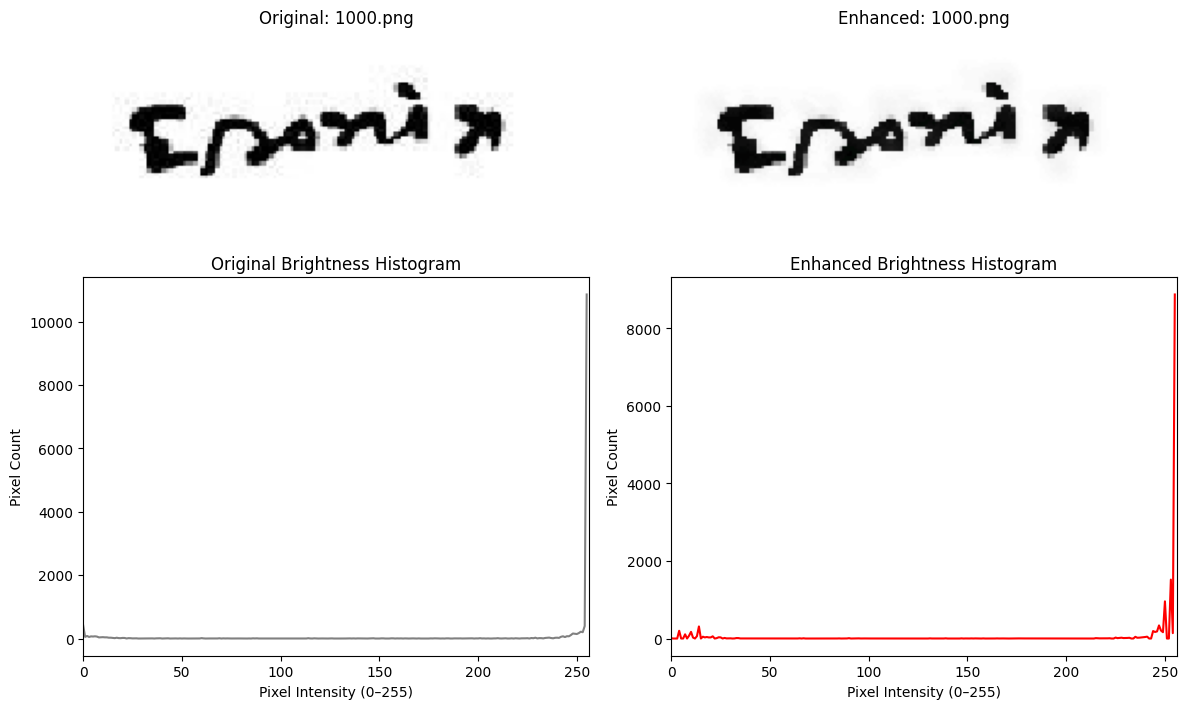

In [5]:
# --- Define paths ---
original_path = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words/1000.png"
enhanced_path = "/kaggle/working/enhanced_training_words/1000.png"

# --- Read images ---
orig = cv2.imread(original_path)
enh = cv2.imread(enhanced_path)

if orig is None or enh is None:
    print("Image not found. Check the file path or name.")
else:
    # Convert to RGB for display
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    enh_rgb = cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)

    # Convert to grayscale for histogram
    gray_orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    gray_enh = cv2.cvtColor(enh, cv2.COLOR_BGR2GRAY)

    # Compute histograms
    hist_orig = cv2.calcHist([gray_orig], [0], None, [256], [0, 256])
    hist_enh = cv2.calcHist([gray_enh], [0], None, [256], [0, 256])

    # --- Plot images and histograms ---
    plt.figure(figsize=(12, 8))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(orig_rgb)
    plt.title("Original: 1000.png")
    plt.axis("off")

    # Enhanced image
    plt.subplot(2, 2, 2)
    plt.imshow(enh_rgb)
    plt.title("Enhanced: 1000.png")
    plt.axis("off")

    # Original histogram
    plt.subplot(2, 2, 3)
    plt.plot(hist_orig, color='gray')
    plt.title("Original Brightness Histogram")
    plt.xlabel("Pixel Intensity (0–255)")
    plt.ylabel("Pixel Count")
    plt.xlim([0, 256])

    # Enhanced histogram
    plt.subplot(2, 2, 4)
    plt.plot(hist_enh, color='red')
    plt.title("Enhanced Brightness Histogram")
    plt.xlabel("Pixel Intensity (0–255)")
    plt.ylabel("Pixel Count")
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.show()


In [6]:
# Contrast metric (standard deviation of pixel intensity)
contrast_orig = np.std(gray_orig)
contrast_enh = np.std(gray_enh)

# Mean brightness
mean_orig = np.mean(gray_orig)
mean_enh = np.mean(gray_enh)

print(f"Original → mean: {mean_orig:.2f}, contrast: {contrast_orig:.2f}")
print(f"Enhanced → mean: {mean_enh:.2f}, contrast: {contrast_enh:.2f}")


Original → mean: 228.81, contrast: 72.40
Enhanced → mean: 229.53, contrast: 70.02


Found 3120 images to process...
✅ All images processed and saved!


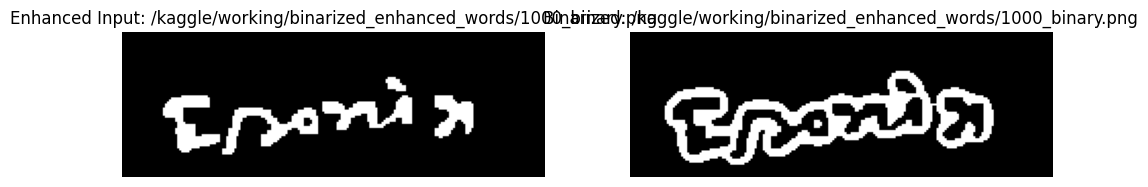

In [7]:
# --- Define paths ---
original_folder = Path("/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words")
enhanced_folder = Path("/kaggle/working/enhanced_training_words")
output_folder = Path("/kaggle/working/binarized_enhanced_words")
output_folder.mkdir(exist_ok=True)

# --- Binarization Function ---
def binarize_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)
    binary = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   15, 10)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    return binary


# --- Process all images in enhanced folder ---
image_files = list(enhanced_folder.glob("*.png"))
print(f"Found {len(image_files)} images to process...")

for img_path in image_files:
    # Read enhanced image
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"❌ Could not read: {img_path}")
        continue

    # Apply binarization
    binary_img = binarize_image(img)

    # Save result
    output_path = output_folder / f"{img_path.stem}_binary.png"
    cv2.imwrite(str(output_path), binary_img)
    # print(f"✓ Saved: {output_path}")

print("All images processed and saved!")

# ---  Display first image ---
if image_files:
    img_path = '/kaggle/working/binarized_enhanced_words/1000_binary.png'
    img = cv2.imread(str(img_path))
    binary_img = binarize_image(img)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Enhanced Input: {img_path}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(binary_img, cmap='gray')
    plt.title(f"Binarized: {img_path}")
    plt.axis("off")

    plt.show()


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths ---
enhanced_folder = Path("/kaggle/working/binarized_enhanced_words")
output_folder = Path("/kaggle/working/binarized_morphological_words")
output_folder.mkdir(exist_ok=True)

# --- Morphological pipeline function ---
def morphological_pipeline(binary_img):
    """Apply morphological cleanup on a binary image"""
    steps = {}
    # Small opening to remove tiny noise
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel_small)
    steps['opened'] = opened

    # Medium closing to connect broken strokes
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_medium)
    steps['final'] = closed

    info = {
        "kernel_small": kernel_small.shape,
        "kernel_medium": kernel_medium.shape
    }
    return steps, info

# --- Process all images in folder ---
image_files = list(enhanced_folder.glob("*.png"))  # All PNG images
print(f"Found {len(image_files)} images to process...")

for image_path in image_files:
    # --- Read enhanced image ---
    enh_img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if enh_img is None:
        print(f"❌ Could not read: {image_path}")
        continue

    # --- Ensure binary ---
    _, binary_img = cv2.threshold(enh_img, 127, 255, cv2.THRESH_BINARY)

    # --- Apply morphological pipeline ---
    steps, info = morphological_pipeline(binary_img)

    # --- Save final cleaned image ---
    output_path = output_folder / f"{image_path.stem}_morphological_final.png"
    cv2.imwrite(str(output_path), steps['final'])
    # print(f"✓ Saved: {output_path}")

print("✅ All images processed successfully!")


Found 3120 images to process...
✅ All images processed successfully!


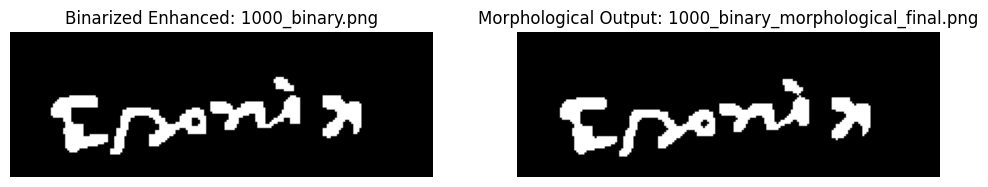

In [11]:
# --- Folders ---
enhanced_folder = Path("/kaggle/working/binarized_enhanced_words")
output_folder = Path("/kaggle/working/binarized_morphological_words")

# --- Example file names ---
example_name = "1000_binary.png"
morph_name = "1000_binary_morphological_final.png"

input_path = enhanced_folder / example_name
output_path = output_folder / morph_name

# --- Display if files exist ---
if input_path.exists() and output_path.exists():
    # Read images in grayscale
    binary_img = cv2.imread(str(input_path), cv2.IMREAD_GRAYSCALE)
    morph_img = cv2.imread(str(output_path), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(binary_img, cmap='gray')
    plt.title(f"Binarized Enhanced: {example_name}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(morph_img, cmap='gray')
    plt.title(f"Morphological Output: {morph_name}")
    plt.axis("off")

    plt.show()
else:
    print(f"❌ One or both images not found:\n{input_path}\n{output_path}")


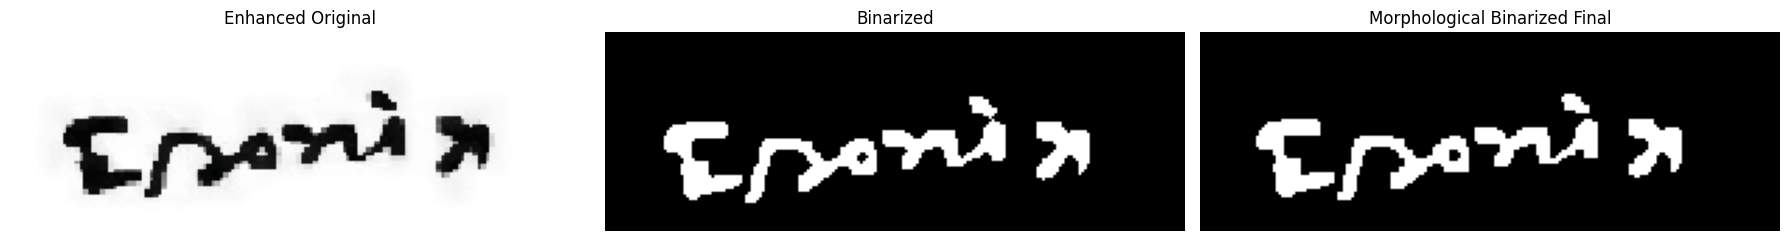

In [17]:
# --- Folders ---
enhanced_folder = Path("/kaggle/working/enhanced_training_words")
morph_folder = Path("/kaggle/working/binarized_morphological_words")
final_folder = Path("/kaggle/working/binarized_enhanced_words")

# --- Example file ---
example_file = "1000.png"  # base name

# --- Paths ---
enhanced_path = enhanced_folder / example_file
final_path = final_folder / "1000_binary.png"
morph_path = morph_folder / "1000_binary_morphological_final.png"

# --- Load images safely ---
def load_image(path):
    if path.exists():
        img = cv2.imread(str(path))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        print(f"File not found: {path}")
        return None

img_enhanced = load_image(enhanced_path)
img_morph = load_image(morph_path)
img_final = load_image(final_path)

# --- Display if all loaded ---
images = [img_enhanced, img_morph, img_final]
titles = ["Enhanced Original", "Binarized", "Morphological Binarized Final"]


if all(img is not None for img in images):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Some images could not be loaded.")